In [19]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [20]:
import pathlib
myFile = 'C:\\Users\\phs-robotics\\robotProgramingMouse\\datasets\\Cone-dataset-1'
#dataset_url ='https://drive.google.com/file/d/1otoAvelPsonJqke6KNJf6aYdBWPrBsLH/view?usp=sharing&confirm=t'
#data_dir = tf.keras.utils.get_file("RESULT",origin=myFile, untar=True)
#data_dir = pathlib.Path(myFile)
data_dir = pathlib.Path(myFile)

optimizer = "Adamax" #https://www.tensorflow.org/api_docs/python/tf/keras/optimizers <-- optimizer list
activationFunction = "relu" #https://www.tensorflow.org/api_docs/python/tf/keras/activations <-- activation functions list
trainingSplit = 0.2 # the % of data that will be used in order to train. To get validation split, do 1-trainingSplit
padding = "same" #same=padding, valid=none


In [21]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

103


# Train model, Prt. 1

In [22]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=trainingSplit,
  subset="training",
  seed=623,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 103 files belonging to 2 classes.
Using 83 files for training.


In [23]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=1-trainingSplit,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 103 files belonging to 2 classes.
Using 82 files for validation.


In [24]:
class_names = train_ds.class_names
print(class_names)

['Blue', 'Red']


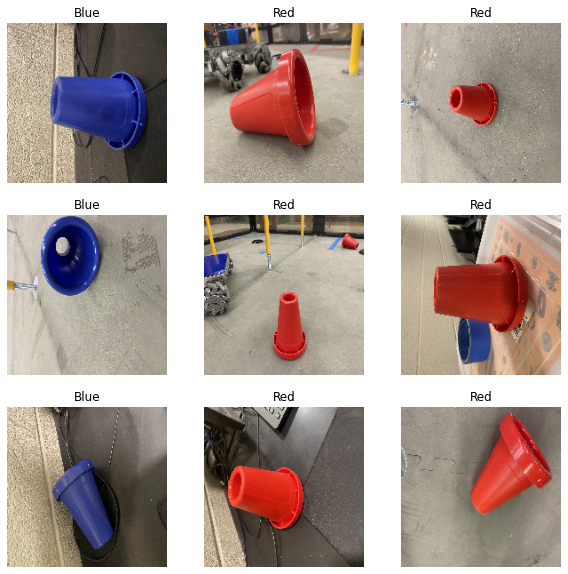

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [29]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding=padding, activation=activationFunction),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding=padding, activation=activationFunction),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding=padding, activation=activationFunction),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=activationFunction),
  layers.Dense(num_classes)
])

In [30]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [32]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
3/3 [==============================] - 5s 2s/step - loss: 4.1838 - accuracy: 0.4096 - val_loss: 0.9694 - val_accuracy: 0.5366
Epoch 2/10
3/3 [==============================] - 2s 596ms/step - loss: 1.3185 - accuracy: 0.4819 - val_loss: 0.9220 - val_accuracy: 0.5366
Epoch 3/10
3/3 [==============================] - 2s 682ms/step - loss: 0.8259 - accuracy: 0.3976 - val_loss: 0.7139 - val_accuracy: 0.4634
Epoch 4/10
3/3 [==============================] - 2s 583ms/step - loss: 0.6921 - accuracy: 0.5181 - val_loss: 0.7196 - val_accuracy: 0.4634
Epoch 5/10
3/3 [==============================] - 2s 572ms/step - loss: 0.6396 - accuracy: 0.5181 - val_loss: 0.5476 - val_accuracy: 0.6951
Epoch 6/10
3/3 [==============================] - 2s 576ms/step - loss: 0.4932 - accuracy: 0.9036 - val_loss: 0.4648 - val_accuracy: 0.9756
Epoch 7/10
3/3 [==============================] - 2s 598ms/step - loss: 0.4767 - accuracy: 0.8554 - val_loss: 0.4013 - val_accuracy: 1.0000
Epoch 8/10
3/3 [=======

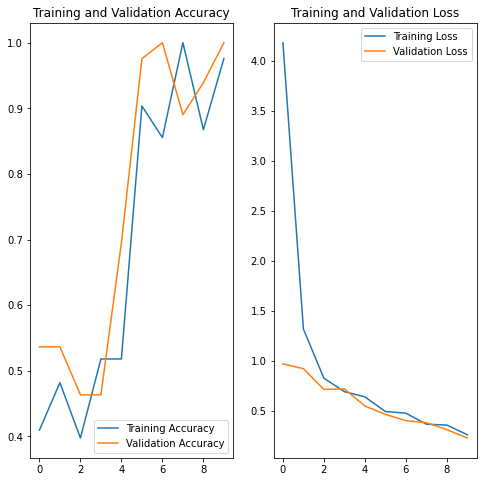

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Optimize and Train New Model

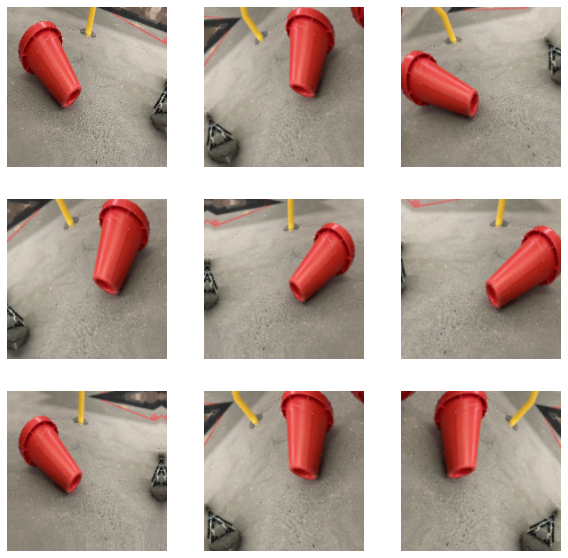

In [34]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [35]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation=activationFunction),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation=activationFunction),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation=activationFunction),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=activationFunction),
  layers.Dense(num_classes, name="outputs")
])

In [36]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [37]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 7s 736ms/step - loss: 1.1612 - accuracy: 0.4337 - val_loss: 0.8479 - val_accuracy: 0.4634
Epoch 2/15
3/3 [==============================] - 2s 736ms/step - loss: 0.5762 - accuracy: 0.6145 - val_loss: 0.6254 - val_accuracy: 0.5366
Epoch 3/15
3/3 [==============================] - 2s 674ms/step - loss: 0.5724 - accuracy: 0.5301 - val_loss: 0.4155 - val_accuracy: 0.9268
Epoch 4/15
3/3 [==============================] - 2s 668ms/step - loss: 0.4128 - accuracy: 0.8795 - val_loss: 0.3731 - val_accuracy: 0.8415
Epoch 5/15
3/3 [==============================] - 2s 685ms/step - loss: 0.3150 - accuracy: 0.9036 - val_loss: 0.2104 - val_accuracy: 0.9756
Epoch 6/15
3/3 [==============================] - 2s 707ms/step - loss: 0.1909 - accuracy: 0.9880 - val_loss: 0.1464 - val_accuracy: 0.9878
Epoch 7/15
3/3 [==============================] - 2s 705ms/step - loss: 0.1250 - accuracy: 0.9880 - val_loss: 0.0903 - val_accuracy: 0.9878
Epoch 8/15
3/3 [====

# Test & Finish Model

In [46]:
sunflower_url = "file:///C:/Users/phs-robotics/robotProgramingMouse/images/coneB3.jpg"
sunflower_path = tf.keras.utils.get_file('coneB3', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 502ms/step
This image most likely belongs to Blue with a 100.00 percent confidence.


In [131]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\PHS-RO~1\AppData\Local\Temp\tmpgmz_nank\assets


INFO:tensorflow:Assets written to: C:\Users\PHS-RO~1\AppData\Local\Temp\tmpgmz_nank\assets


In [132]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [133]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_7_input'], 'outputs': ['outputs']}}

In [134]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [135]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

assert np.allclose(predictions, predictions_lite)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

ValueError: Invalid Input name (sequential_1_input) for SignatureDef